In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypoman
import scipy.spatial
import polytope
import torch
import math

import pynever.strategies.abstraction as abst
import pynever.nodes as nodes
import pynever.strategies.verification as ver
import pynever.networks as networks
import pynever.utilities as utils
import pynever.strategies.conversion as conv


def plot_star(p_star: abst.Star, show=False, title=None, color = np.array([0.5, 0.5, 1])):

    #color = np.random.rand(3)
    alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
    x_vertexes = []
    for v in alpha_vertexes:
        v_ver = np.zeros((v.shape[0], 1))
        for k in range(v.shape[0]):
            v_ver[k, 0] = v[k]
        new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
        x_vertexes.append(new_x_v)

    x1_plot = []
    x2_plot = []
    for v in x_vertexes:
        x1_plot.append(v[0, 0])
        x2_plot.append(v[1, 0])

    for k in range(len(x1_plot)):
        for j in range(len(x1_plot)):
            plt.plot([x1_plot[k], x1_plot[j]], [x2_plot[k], x2_plot[j]], color=color)

    plt.scatter(x1_plot, x2_plot, color=color)
    if show:
        if title is not None:
            plt.title(title)
        plt.grid()


def plot_starset(p_starset: abst.StarSet, title, color = np.array([0.5, 0.5, 1])):
    for p_star in p_starset.stars:

        plot_star(p_star, color=color)

    if title is not None:
        plt.title(title)
    plt.grid()


def get_star_extreme_points(p_star: abst.Star):

    x_vertexes = []
    alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
    for v in alpha_vertexes:
        v_ver = np.zeros((v.shape[0], 1))
        for k in range(v.shape[0]):
            v_ver[k, 0] = v[k]
        new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
        new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
        x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)

    return x_vertexes

def get_starset_extreme_points(p_starset: abst.StarSet):
    x_vertexes = []
    for p_star in p_starset.stars:
        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
            x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)
    return x_vertexes


def plot_convex_hull(points: np.ndarray, title = None, color=None, alpha=1, label=None):

    hull = scipy.spatial.ConvexHull(points)
    vertexes = points[hull.vertices, :]
    vertexes = np.vstack((vertexes, vertexes[0, :]))
    if color is None:
        plt.fill(vertexes[:, 0], vertexes[:, 1], alpha=0.5, label=label)
    else:
        plt.fill(vertexes[:, 0], vertexes[:, 1], color=color, alpha=alpha, label=label)
    
    if title is not None:
        plt.title(title)
    plt.grid()


def print_star_data(p_star: abst.Star):

    print("PREDICATE CONSTRAINTS:")
    for row in range(p_star.predicate_matrix.shape[0]):
        constraint = ""
        for col in range(p_star.predicate_matrix.shape[1]):
            if p_star.predicate_matrix[row, col] < 0:
                sign = "-"
            else:
                sign = "+"
            constraint = constraint + f"{sign} {abs(p_star.predicate_matrix[row, col])} * x_{col} "

        constraint = constraint + f"<= {p_star.predicate_bias[row, 0]}"
        print(constraint)

    print("VARIABLES EQUATIONS:")
    for row in range(p_star.basis_matrix.shape[0]):
        equation = f"z_{row} = "
        for col in range(p_star.basis_matrix.shape[1]):
            if p_star.basis_matrix[row, col] < 0:
                sign = "-"
            else:
                sign = "+"
            equation = equation + f"{sign} {abs(p_star.basis_matrix[row, col])} * x_{col} "

        if p_star.center[row, 0] < 0:
            c_sign = "-"
        else:
            c_sign = "+"
        equation = equation + f"{c_sign} {abs(p_star.center[row, 0])}"
        print(equation)

In [2]:
sig = lambda x: 1.0 / (1.0 + np.exp(-x))
sig_fod = lambda x: np.exp(-x) / np.power(1 + np.exp(-x), 2)

def x_intersec(lb, ub):
    return (sig_fod(lb) * lb - sig_fod(ub) * ub + sig(ub) - sig(lb)) / (sig_fod(lb) - sig_fod(ub))

def y_intersec(x_in, lb, ub):
    return sig_fod(lb) * (x_in - lb) + sig(lb)

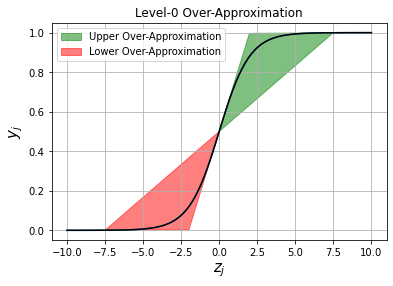

In [3]:
# Plot Sigmoid
lb = -7.5
ub = 7.5
boundary = 0
sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points))

x_int_up = x_intersec(boundary, ub)
y_int_up = y_intersec(x_int_up, boundary, ub)

x_int_lo = x_intersec(lb, boundary)
y_int_lo = y_intersec(x_int_lo, lb, boundary)

overapprox_up = polytope.qhull(np.array([[x_int_up, y_int_up], [boundary, sig(boundary)], [ub, sig(ub)]]))
overapprox_lo = polytope.qhull(np.array([[x_int_lo, y_int_lo], [lb, sig(lb)], [boundary, sig(boundary)]]))

plot_convex_hull(overapprox_up.vertices, color='green', alpha=0.5, label="Upper Over-Approximation")
plot_convex_hull(overapprox_lo.vertices, color='red', alpha=0.5, label="Lower Over-Approximation")

sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points), color='black')

plt.xlabel("$z_j$", size=15)
plt.ylabel("$y_j$", size=15)
plt.grid()
plt.title("Level-0 Over-Approximation")
plt.legend()
plt.savefig(f"sig-over.pdf")
plt.show()

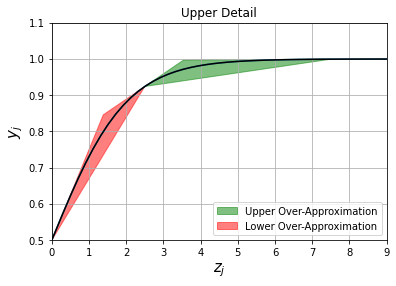

In [4]:
# Plot Sigmoid
lb = 0
ub = 7.5
boundary = 2.5
sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points))

x_int_up = x_intersec(boundary, ub)
y_int_up = y_intersec(x_int_up, boundary, ub)

x_int_lo = x_intersec(lb, boundary)
y_int_lo = y_intersec(x_int_lo, lb, boundary)

overapprox_up = polytope.qhull(np.array([[x_int_up, y_int_up], [boundary, sig(boundary)], [ub, sig(ub)]]))
overapprox_lo = polytope.qhull(np.array([[x_int_lo, y_int_lo], [lb, sig(lb)], [boundary, sig(boundary)]]))

plot_convex_hull(overapprox_up.vertices, color='green', alpha=0.5, label="Upper Over-Approximation")
plot_convex_hull(overapprox_lo.vertices, color='red', alpha=0.5, label="Lower Over-Approximation")

sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points), color='black')

plt.xlabel("$z_j$", size=15)
plt.ylabel("$y_j$", size=15)
plt.xlim([0,9])
plt.ylim([0.5,1.1])
plt.grid()
plt.title("Upper Detail")
plt.legend()
plt.savefig(f"sig-over-up.pdf")
plt.show()

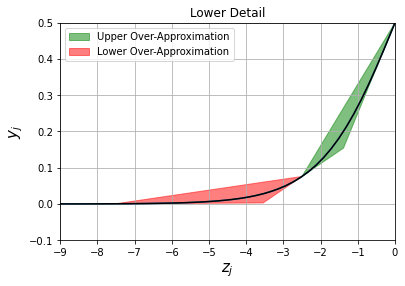

In [5]:
# Plot Sigmoid
lb = -7.5
ub = 0
boundary = -2.5
sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points))

x_int_up = x_intersec(boundary, ub)
y_int_up = y_intersec(x_int_up, boundary, ub)

x_int_lo = x_intersec(lb, boundary)
y_int_lo = y_intersec(x_int_lo, lb, boundary)

overapprox_up = polytope.qhull(np.array([[x_int_up, y_int_up], [boundary, sig(boundary)], [ub, sig(ub)]]))
overapprox_lo = polytope.qhull(np.array([[x_int_lo, y_int_lo], [lb, sig(lb)], [boundary, sig(boundary)]]))

plot_convex_hull(overapprox_up.vertices, color='green', alpha=0.5, label="Upper Over-Approximation")
plot_convex_hull(overapprox_lo.vertices, color='red', alpha=0.5, label="Lower Over-Approximation")

sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points), color='black')

plt.xlabel("$z_j$", size=15)
plt.ylabel("$y_j$", size=15)
plt.xlim([-9,0])
plt.ylim([-0.1,0.5])
plt.grid()
plt.title("Lower Detail")
plt.legend()
plt.savefig(f"sig-over-low.pdf")
plt.show()

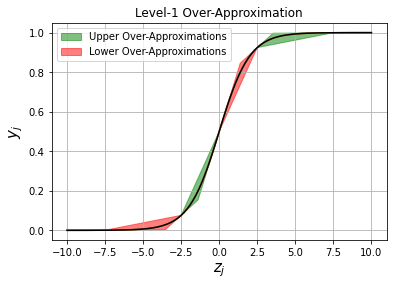

In [6]:
# Plot Sigmoid
params = [(-7.5, 0, -2.5), (0, 7.5, 2.5)]
overapproxs = []
i = 0
for (lb, ub, boundary) in params:
    sig_points = np.linspace(-10,10,100)
    plt.plot(sig_points, sig(sig_points))

    x_int_up = x_intersec(boundary, ub)
    y_int_up = y_intersec(x_int_up, boundary, ub)

    x_int_lo = x_intersec(lb, boundary)
    y_int_lo = y_intersec(x_int_lo, lb, boundary)

    overapprox_up = polytope.qhull(np.array([[x_int_up, y_int_up], [boundary, sig(boundary)], [ub, sig(ub)]]))
    overapprox_lo = polytope.qhull(np.array([[x_int_lo, y_int_lo], [lb, sig(lb)], [boundary, sig(boundary)]]))
    
    if i == 0:
        plot_convex_hull(overapprox_up.vertices, color='green', alpha=0.5, label="Upper Over-Approximations")
        plot_convex_hull(overapprox_lo.vertices, color='red', alpha=0.5, label="Lower Over-Approximations")
    else:
        plot_convex_hull(overapprox_up.vertices, color='green', alpha=0.5)
        plot_convex_hull(overapprox_lo.vertices, color='red', alpha=0.5)
        
    i += 1

sig_points = np.linspace(-10,10,100)
plt.plot(sig_points, sig(sig_points), color='black')

plt.xlabel("$z_j$", size=15)
plt.ylabel("$y_j$", size=15)
plt.grid()
plt.title("Level-1 Over-Approximation")
plt.legend()
plt.savefig(f"sig-over-ref.pdf")
plt.show()